# Neural Network Class for handwritten digits

In [399]:
import pandas as pd
import numpy as np
import math
import random
import scipy
import pickle
import os
import gzip

from matplotlib import pyplot as plt

## Reading test and training data?

In [405]:
def load_data1():
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():

    tr_d, va_d, te_d = load_data1()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [406]:
training, _, testing = load_data_wrapper()

# Creating a network class:

input: object is a list. The number of items in the list represents the number of layers, where the first input is the amount of nodes in the input layer, where the items up to the final item are the the amount of nodes in each hidden layer, where finally we have the final item being the amount of nodes in the output layer.

more formally, we have:

object[0] := |nodes in the input layer|,
object[1: len(object)] := |nodes in each hidden layer|,
object[-1] := |nodes in the final layer|

These biases and weights are initialised with a gaussian distribution of mean 0 and std 1

In [415]:
def sigmoid(x):
    #return 1.0/(1.0+np.exp(-x))
    return scipy.special.expit(x)


class network1(object):
    
    def __init__(self, sizes):
        
        self.number_of_layers = len(sizes)
        
        self.sizes = sizes
        
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
        
    def forward_prop(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(w.dot(a) + b)
        return a
    
    
    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.forward_prop(x)), y) for (x, y) in test_data]
        
        return sum(int(x == y) for (x, y) in test_results)
    
    #we note that it is difficult to quickly compute the gradient of this big function space.
    #hence we can take a stochastic approach, by seperating the function into equal sizes of batches which we can train on
    #assuming we have enough batches as a sample, we can say that approximatley the average value of the gradient of the cost function from each 
    #batch will be roughly equal to the average over the entire function space
    

    def stochastic_gradient_descent(self, training_data, epochs, batch_size, eta, test_data = None):
        
        if test_data:
            n_test = len(test_data)
        
        n = len(training_data)
        
        #performing calcs for the number of epochs we assign (assumes the data is already randomly shuffled)
        for i in range(epochs):
            
            
            #randomly shuffle the input data
            random.shuffle(training_data)
            
            #creating n batches of batch size: batch_size
            training_batches = [training_data[k : k + batch_size] for k in range(0, n, batch_size)]
            
            for batch in training_batches:
                #applying a step of gradient descent to each batch
                self.update_batch(batch, eta)
                
            if test_data:
                 print("Epoch {0}: {1} / {2}".format(i, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(i))
                
            
            
    def update_batch(self, batch, eta):
        
        #pd of cost function wrt bias
        n_b = [np.zeros(b.shape) for b in self.biases]
        
        #pd of cost function wrt weight
        n_w = [np.zeros(w.shape) for w in self.weights]


        for x,y in batch:
            
            dCdB, dCdW = self.back_propagation(x,y)

            n_b = [nb + d_nb for nb, d_nb in zip(n_b, dCdB)]
            n_w = [nw + d_nw for nw, d_nw in zip(n_w, dCdW)]
        
        self.weights = [w-(eta/len(batch))*nw for w, nw in zip(self.weights, n_w)]
        
        self.biases = [b-(eta/len(batch))*nb for b, nb in zip(self.biases, n_b)]
    
    
    #x is the input layer and y is the output layer, which label it is supposed to be
    def back_propagation(self, x, y):
        #pd of cost function wrt bias
        nb = [np.zeros(b.shape) for b in self.biases]
        
        #pd of cost function wrt weight
        nw = [np.zeros(w.shape) for w in self.weights]
        
        #this is empty initially and stores the weighted sum with the bias added into it
        z_lst = []
        
        #initial activation is the input layer
        a = x
    
        #the list of activations, we note that the input layers activations are already set, hence why we can preset them
        a_lst = [x]
        
        #computing the forward propagation
        for b, w in zip(self.biases, self.weights):
            #finding the weighted sum and storing it
            z = w.dot(a) + b
            z_lst.append(z)

            #finding the next activation and storing it
            a = sigmoid(z)
            a_lst.append(a)
            
        
        #error in output layer, hadamard product of pd of the cost function with the rate of change of the activation function (sigmoid)
        delta = (a_lst[-1] - y) * (sigmoid(z_lst[-1])*(1.0-sigmoid(z_lst[-1])))
        
        nb[-1] = delta
        nw[-1] = delta.dot(a_lst[-2].T)
        
        #backpropogate said error
        for l in range(2, self.number_of_layers):
            delta = ((self.weights[-l+1].T).dot(delta)) * (sigmoid(z_lst[-l])*(1-sigmoid(z_lst[-l])))
            nb[-l] = delta
            nw[-l] = delta.dot(a_lst[-l-1].T)
            
        #output
        return (nb, nw)  

In [408]:
net = network1([784,16, 16, 10])
net.stochastic_gradient_descent(list(training), 30, 10, 3.0, test_data=list(testing))

Epoch 0: 8974 / 10000
Epoch 1: 9096 / 10000
Epoch 2: 9138 / 10000
Epoch 3: 9199 / 10000
Epoch 4: 9242 / 10000
Epoch 5: 9191 / 10000
Epoch 6: 9306 / 10000
Epoch 7: 9225 / 10000
Epoch 8: 9247 / 10000
Epoch 9: 9320 / 10000
Epoch 10: 9306 / 10000
Epoch 11: 9324 / 10000
Epoch 12: 9306 / 10000
Epoch 13: 9324 / 10000
Epoch 14: 9356 / 10000
Epoch 15: 9313 / 10000
Epoch 16: 9363 / 10000
Epoch 17: 9291 / 10000
Epoch 18: 9319 / 10000
Epoch 19: 9341 / 10000
Epoch 20: 9357 / 10000
Epoch 21: 9390 / 10000
Epoch 22: 9339 / 10000
Epoch 23: 9296 / 10000
Epoch 24: 9304 / 10000
Epoch 25: 9395 / 10000
Epoch 26: 9353 / 10000
Epoch 27: 9380 / 10000
Epoch 28: 9362 / 10000
Epoch 29: 9404 / 10000


prediction:  [5]
label:  5


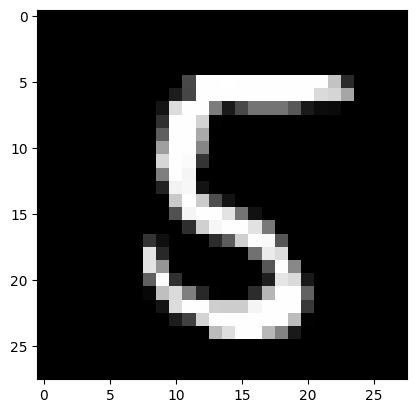

In [414]:
net.test_predictions(1340)